# Supplementary : Gaussian Mixture Model

데이터가 표준적인 분포를 따른다고 보기 힘든 경우, **혼합 모형**을 고려해볼 수 있습니다. 

**가우시안 혼합 모형**은 대표적인 혼합 모형으로, 많은 경우 **분류**를 위한 알고리즘으로 활용됩니다. 

강의에서는 베이지안 관점에서 혼합 모형을 소개하는 데 그쳤다면, 이하에서는 보다 실용적인 관점에서 가우시안 혼합 모형을 가볍게 다뤄보도록 하겠습니다.

## Basics

GMM에서 특정 데이터포인트 $x_i$의 확률밀도는 다음과 같이 **정규분포의 선형결합**으로 표현할 수 있습니다.

$$
\begin{aligned}
p(x_i) = \sum _{c} \pi _c &{\mathcal {N}} (x_i ; \ \ \mu_c, \Sigma_c) \\[10pt]
\text{where } \pi_c &\text{ : mixing weight of cluster c}
\end{aligned}
$$

GMM의 관점에서 **분류** 문제의 목표는 위 모형을 결정해주는 **파라미터** $\pi_c$, $\mu_c$, $\Sigma_c$를 최적화하는 것입니다. 이러한 최적화를 위해 **가능도**(likelihood)를 이용할 수 있습니다.

## EM Algorithm

추정-최대화 알고리즘(**Expectation-Maximization Algorithm**)이란 각 군집에 속할 사후확률을 가중치로 변환하여 혼합모델의 파라미터를 결정하는 알고리즘입니다. 

유사한 **비지도학습**인 k-means 알고리즘에서와 같이, 수렴은 보장되어 있으나 local optimum의 위험에서 자유롭지 못합니다.

다만 k-means 알고리즘과 차이가 있다면, EM algorithm은 특정 군집에 대한 멤버십이 확률적으로 표현되는 **soft clustering**이라는 점입니다. 

특정 데이터포인트 $x_i$가 주어져있을 때, 특정 군집 $c_j$에 속할 사후확률은 **베이즈 룰**에 의해 다음과 같이 표현할 수 있습니다.

$$
\begin{aligned}
r_{ij} &= p(c_j \mid x_i) \\[10pt]
&= \frac {p(x_i \mid c_j) \cdot p(c_j)} {\sum_{c} p(x_i \mid c) \cdot p(c)} \\[10pt]
&= \frac {p(x_i \mid c_j) \cdot \pi_{c_j}} {\sum_{c} p(x_i \mid c) \cdot \pi_{c}} \\
\end{aligned}
$$

사후확률을 구했다면, **최대가능도추정량**을 이용해 다음과 같이 각 군집의 파라미터를 추정할 수 있습니다. 이러한 추정 과정을 반복해주면 됩니다.

$$
\begin{aligned}
\pi_{c_j} &= \frac { \sum_i r_{ij} } { \sum_{i, j} r_{ij} } \\[10pt]
\mu_{c_j} &= \frac {\sum_i r_{ij} x_i }   { \sum_i r_{ij} } \\[10pt]
\Sigma_{c_j} &= \frac {\sum_i r_{ij} (x_i- \mu_{c_j})^T (x_i- \mu_{c_j}) }   { \sum_i r_{ij} } \\[10pt]
\end{aligned}
$$

알고리즘을 정리하면 다음과 같습니다.

1. **초기화** : 파라미터 $\pi_c$, $\mu_c$, $\Sigma_c$의 **random initialization**

2. **추정**(Expecatation) : $x_i$가 $c_j$에 속할 사후확률 $r_{ij}$ 계산

3. **최대화**(Maximization) : MLE 공식을 이용한 파라미터 $\pi_c$, $\mu_c$, $\Sigma_c$ 업데이트

4. **종결** : Log Likelihood가 지정 조건보다 작아지면 알고리즘 종료

## Application

In [2]:
mixture = read.csv("mixture.csv", header=FALSE)
DATA    = mixture[,1]

### Random Initialization

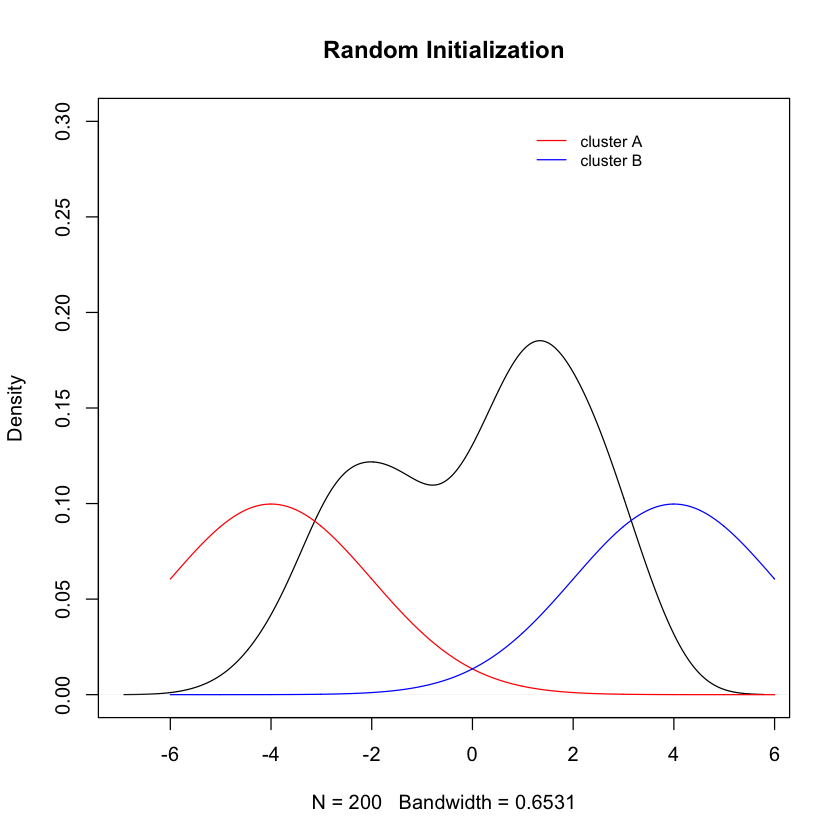

In [4]:
Amean = -4; Asd = 2; Awght = .5
Bmean = 4;  Bsd = 2; Bwght = .5

likelihood = posterior = matrix(nrow=length(DATA), ncol=2, dimnames=list(NULL, c("A","B")))

plot(density(DATA), ylim=c(0,.3), main="Random Initialization")
support = seq(-6,6,by=.01)
lines(support, Awght*dnorm(support, Amean, Asd), col="red")
lines(support, Bwght*dnorm(support, Bmean, Bsd), col="blue")
legend(1, .3, legend=c("cluster A", "cluster B"),
       col=c("red", "blue"), lty=1, cex=0.8, box.lty=0)

### Expectation and Maximization

In [5]:
update = function()
{
  # Expectation
  likelihood[,1] = sapply(DATA, function(x) dnorm(x, Amean, Asd))
  likelihood[,2] = sapply(DATA, function(x) dnorm(x, Bmean, Bsd))
  
  posterior = prop.table(likelihood %*% diag(c(Awght, Bwght)), 1)
  responsibility = apply(posterior, 2, sum)

  # Maximization
  Amean <<- sum(DATA * posterior[,1]) / responsibility[1]
  Asd   <<- sqrt(sum((DATA - Amean)^2 * posterior[,1]) / responsibility[1])
  Awght <<- responsibility[1] / sum(responsibility)
  
  Bmean <<- sum(DATA * posterior[,2]) / responsibility[2]
  Bsd   <<- sqrt(sum((DATA - Bmean)^2 * posterior[,2]) / responsibility[2])
  Bwght <<- responsibility[2] / sum(responsibility)
}

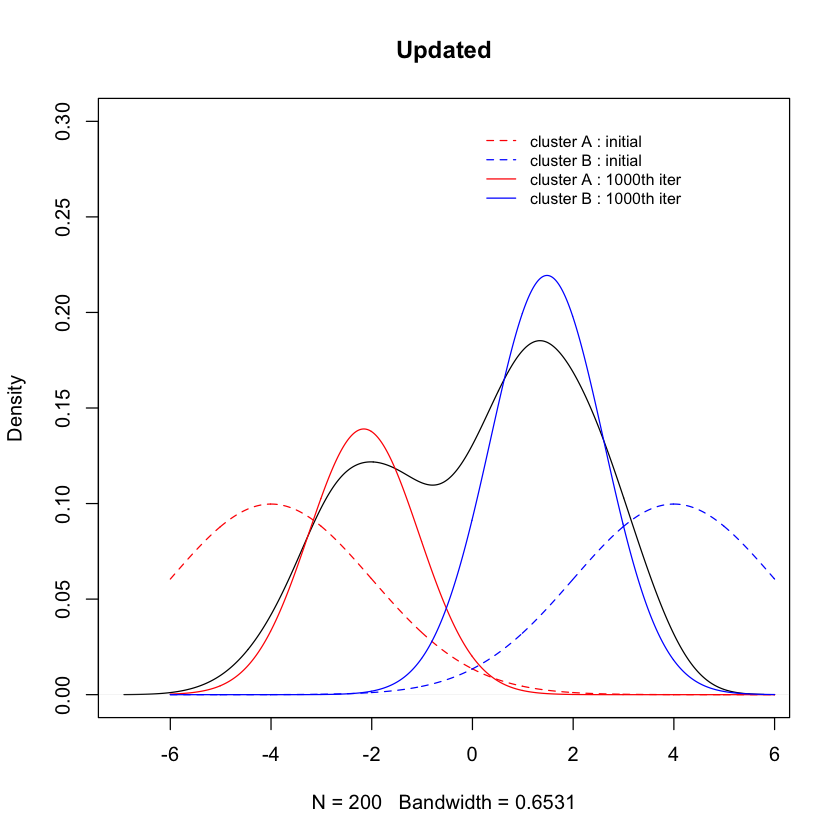

In [6]:
plot(density(DATA), ylim=c(0,.3), main="Updated")
lines(support, Awght*dnorm(support, Amean, Asd), col="red", lty=2)
lines(support, Bwght*dnorm(support, Bmean, Bsd), col="blue", lty=2)

for (i in 1:1e3) update()

lines(support, Awght*dnorm(support, Amean, Asd), col="red", lty=1)
lines(support, Bwght*dnorm(support, Bmean, Bsd), col="blue", lty=1)

legend(0, .3, legend=c("cluster A : initial", "cluster B : initial", "cluster A : 1000th iter", "cluster B : 1000th iter"),
       col=c("red", "blue", "red", "blue"), lty=c(2,2,1,1), cex=0.8, box.lty=0)

### Verification by Sampling

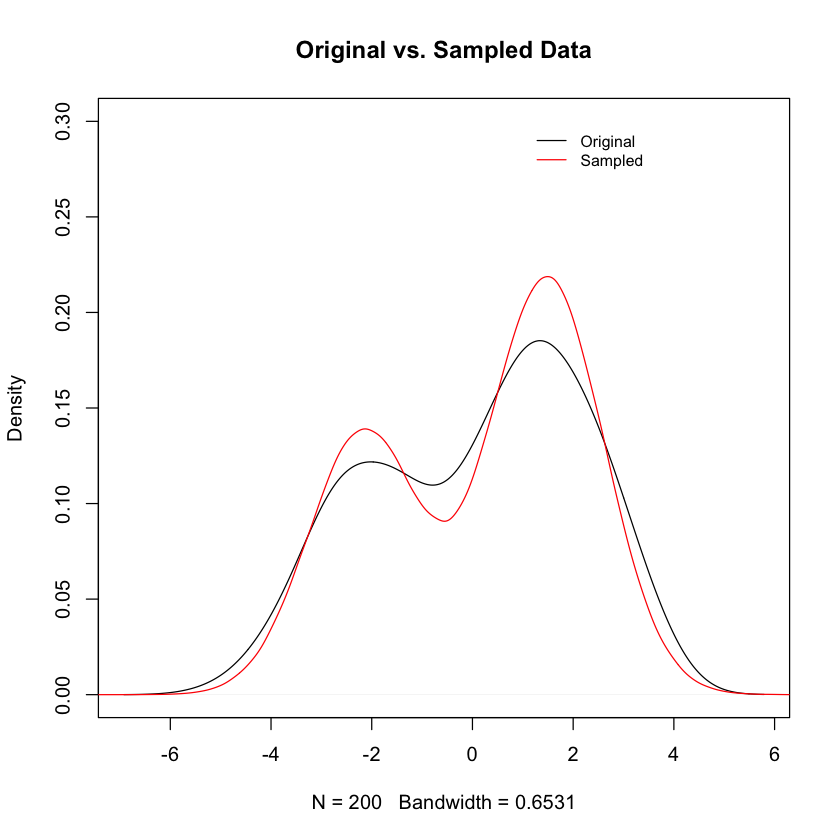

In [7]:
samp = sample(c("A", "B"), 1e6, replace=T, prob=c(Awght, Bwght))
samp = c(rnorm(sum(samp=="A"), Amean, Asd),
         rnorm(sum(samp=="B"), Bmean, Bsd))

plot(density(DATA), ylim=c(0,.3), main="Original vs. Sampled Data")
lines(density(samp), col="red")
legend(1, .3, legend=c("Original", "Sampled"),
       col=c("black", "red"), lty=1, cex=0.8, box.lty=0)